# Simplified system for calcium dynamics in Purkinje neurons

Geometry is divided into 4 domains; two volumes and two surfaces:
- plasma membrane (PM)
- Cytosol
- ER membrane
- ER lumen (ER interior)

This model describes the response of calcium to a prescribed release of IP3 at the PM. IP3 binds to the IP3R and triggers release of calcium from the ER. Calcium also enters via a prescribed influx at the PM and also releases from the ER through ryanodine receptors (RyRs). Calcium buffering in the Cytosol (binding to CD28k or parvalbumin) is modeled explicitly via reactions, whereas buffering in the ER (primarily binding to calreticulin) is included implicitly by scaling fluxes and setting an effective diffusion coefficient for calcium. Calcium exits the cell via PMCA and NCX fluxes and is pumped back into the ER through SERCA pumps.

Overall, the distribution of species modeled are:
- PM: no species, just reactions and prescribed fluxes
- Cytosol: IP3, Calcium, CD28k, and parvalbumin
- ER membrane: 6 species - 3 states of the RyRs and 3 states of the IP3Rs
- ER volume: ER calcium (buffering is implicit)

We therefore have 11 variables to solve for, and only the volumetric species (those in the ER volume or Cytosol) have diffusive forms. The species living in the PM or ERm are effectively described by ODEs, as we neglect surface diffusion in this case.

```

In [1]:
import dolfin as d
import sympy as sym
import numpy as np

from stubs import unit, config, common, mesh, model
from stubs.model_assembly import Compartment, Parameter, Reaction, Species, sbmodel_from_locals

import os
import petsc4py.PETSc as PETSc
from matplotlib import pyplot as plt

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'


First, we define the various units for the inputs

In [2]:
# Aliases - base units
uM = unit.uM
um = unit.um
nm = unit.nm
molecule = unit.molecule
sec = unit.sec
dimensionless = unit.dimensionless
# Aliases - units used in model
D_unit = um**2 / sec
flux_unit = uM * um / sec
vol_unit = uM
surf_unit = molecule / um**2

In [3]:
# these are conversion factors used in the original model, not all are used in this simplified iteration here
def zeta_units(z):
    "Convert um to (molecule/um**2)/uM (multiply by 602.2140857)"
    return ((z).to(molecule/um**2/uM)).magnitude
# ====================== Geometry ===================== 
# Estimated diameter of soma
L_soma        = 15*um # estimated from tomographic data
# Estimated distance from PM to nucleus
r_soma        = 6*um # estimated from tomographic data
# volume fractions (relative to soma)
nu_Cyto       = 0.6  # estimated
nu_er         = 0.12 # estimated from tomographic data
# area fractions
eta_psdm_pm   = 1/8 #0.125 # estimated from spine data
# volume to area fractions [L]
zeta = dict()
zeta['er_erm']   = 0.15*um # estimate from tomographic data
zeta['Cyto_pm']  = 3*nu_Cyto*L_soma/2 # (4/3*pi*(Lsoma/2)**3)*nu_Cyto / (4*pi*(Lsoma/2)**2)
zeta['soma_pm']  = zeta['Cyto_pm']/nu_Cyto
zeta['Cyto_erm'] = nu_Cyto/nu_er*zeta['er_erm']
zeta['psd_psdm'] = 50*nm  # 500x500x50 size of PSD
zeta['psd_pm']   = zeta['psd_psdm']*eta_psdm_pm # 
# 1 molecule / (500*500*50 nm**3) = 0.132843123 uM
zeta['psdcount_pm'] = 0.132843123*zeta['psd_pm'] 
zeta['psdcount_psdm'] = 0.132843123*zeta['psd_psdm']
# uM/count -> molecule/um**2
print("Conversion factors:")
for name, z in zeta.items():
    print(f"{name} [um] = {z.to(um).magnitude}")
    zeta[name] = zeta_units(z)
    print(f"{name} = {zeta[name]}")

Conversion factors:
er_erm [um] = 0.15
er_erm = 90.33211285499995
Cyto_pm [um] = 13.499999999999998
Cyto_pm = 8129.890156949995
soma_pm [um] = 22.499999999999996
soma_pm = 13549.816928249991
Cyto_erm [um] = 0.75
Cyto_erm = 451.6605642749998
psd_psdm [um] = 0.05
psd_psdm = 30.110704284999994
psd_pm [um] = 0.00625
psd_pm = 3.763838035624999
psdcount_pm [um] = 0.00083026951875
psdcount_pm = 0.49999999911861015
psdcount_psdm [um] = 0.00664215615
psdcount_psdm = 3.999999992948881


Next we generate the model.

In [4]:
def make_model(input_flag_val):
    # input_flag_val determines whether the input is on or off
    # =============================================================================================
    # Species
    # =============================================================================================
    # name, initial concentration, concentration units, diffusion, diffusion units, compartment
    Ca = Species("Ca", 0.06, vol_unit, 220.0, D_unit, "Cyto") # if we reduce this diffusion coefficient, the system may diverge
    IP3 = Species("IP3", 0.11, vol_unit, 200.0, D_unit, "Cyto")
    PV_Ca0    = 0.06*50 / (0.95/107 + 0.06) # 43.555, computed as SS conc
    PV_Ca     = Species('PV_Ca'    , PV_Ca0    , uM , 43 , um**2/sec , 'Cyto' , 'buffer')
    CD28k_hm0 = 0.06**2*100 / (0.823*(0.473+0.06)+0.06**2) # 0.814, computed as SS conc
    CD28k_hm  = Species('CD28k_hm' , CD28k_hm0 , uM , 20 , um**2/sec , 'Cyto' , 'buffer')
    ip3r_tot = 200 # molecules/um^2 
    unit.define(f'ip3r_dimension = {ip3r_tot}*molecule/um**2')
    ip3r_0      = Species('ip3r_0'      ,  0.784137 , unit.ip3r_dimension , 0 , um**2/sec , 'ERm')
    ip3r_ip3    = Species('ip3r_ip3'    ,  0.003343 , unit.ip3r_dimension , 0 , um**2/sec , 'ERm')
    ip3r_ip3_ca = Species('ip3r_ip3_ca' ,  0.000802 , unit.ip3r_dimension , 0 , um**2/sec , 'ERm')
    ryr_x = Species('ryr_x', 0, dimensionless, 0, um**2/sec, 'ERm') # leaky integrator
    ryr_y = Species('ryr_y', 0, dimensionless, 0, um**2/sec, 'ERm') # open
    ryr_z = Species('ryr_z', 0, dimensionless, 0, um**2/sec, 'ERm') # refractory
    CaER = Species("CaER", 150.0, vol_unit, 6.27, D_unit, "ER") # effective D due to buffering

    # =============================================================================================
    # Compartments
    # =============================================================================================
    # name, topological dimensionality, length scale units, marker value
    Cyto = Compartment("Cyto", 3, um, 1)
    PM = Compartment("PM", 2, um, 10)
    ER = Compartment("ER", 3, um, 2)
    ERm = Compartment("ERm", 2, um, 12)

    PM.specify_nonadjacency(['ERm', 'ER'])
    ERm.specify_nonadjacency(['PM'])

    # =============================================================================================
    # Parameters and Reactions
    # =============================================================================================
    # define pulse functions for use in stimulus functions
    step = lambda t,t0: sym.Heaviside(t-t0)
    estep = lambda t,t0,m: 1 / (1+sym.exp(m*(t0-t)))
    estep_decay = lambda t,t0,m,tau: sym.exp((t0-t)/tau) * estep(t,t0,m)
    estep_decayI = lambda t,t0,m,tau: tau*(1-sym.exp((t0-t)/tau)) * estep(t,t0,m)
    astep  = lambda t,t0,m: (1+m*(t-t0)/(1+m**2*(t-t0)**2)**(1/2))/2
    astepI = lambda t,t0,m: (1+m**2*(t-t0)**2)**(1/2)/(2*m) + (t-t0)/2 # Integral of astep
    astep_rect = lambda t0,tf,m: astep(t,t0,m) - astep(t,tf,m) # Rectangular pulse from t0 to tf
    astep_rectI = lambda t0,tf,m: astepI(t,t0,m) - astepI(t,tf,m) # Integral of rectangular pulse from t0 to tf
    astep_str = lambda t,t0,m: f"(0.5+{m}/2*({t}-{t0})/(1+({m}*({t}-{t0}))**2)**0.5)"
    t = sym.Symbol('t')

    # ========================= Plasma membrane reactions (module a) =============================
    # Ca2+ flux VGCC - simple spike PF
    # (03/03/22): Doi et al uses 5 pulses at 100Hz (10ms apart), each releasing 1500 ions over 1ms
    # Spikes are at 10ms, 20ms, 30ms, 40ms, 50ms
    input_flag = Parameter('input_flag', input_flag_val, dimensionless) # flag to change to set stimulus on (1) or off (0)
    simple_spike_flux = 1.5e6 * zeta['psdcount_pm']
    a1_ti = [0.01, 0.02, 0.03, 0.04, 0.05]
    a1_dt = 0.001
    a1_m = 20000 # rise time of <100ns both sides
    a1_on_expr        = simple_spike_flux * sum([astep_rect(a1_t, a1_t+a1_dt, a1_m) for a1_t in a1_ti])
    a1_on_preint_expr = simple_spike_flux * sum([astep_rectI(a1_t, a1_t+a1_dt, a1_m) for a1_t in a1_ti])
    a1_on = Parameter.from_expression('a1_on', a1_on_expr, molecule/(um**2 * sec), group='vgcc',
                                    use_preintegration=True, preint_sym_expr=a1_on_preint_expr)

    a1    = Reaction('a1', [], ['Ca'], {"k": "a1_on", 'flag': 'input_flag'}, eqn_f_str='flag*k', explicit_restriction_to_domain='PM')   
    
    # Ca2+ flux VGCC - complex spike CF
    # (03/03/22): Doi et al uses 5000 ions over 2ms -> 2500 ions / ms = 2.5e6 ions / s.
    complex_spike_flux = 2.5e6 * zeta['psdcount_pm'] # 5e6 molecules / (um**2 * s) [for 2 ms]
    a2_t0 = 0.100
    a2_tf = 0.102
    a2_m  = 20000 # rise time of <100ns both sides
    a2_on_expr        = complex_spike_flux * astep_rect(a2_t0,a2_tf,a2_m)  
    a2_on_preint_expr = complex_spike_flux * astep_rectI(a2_t0,a2_tf,a2_m) 
    a2_on = Parameter.from_expression('a2_on', a2_on_expr, molecule/(um**2 * sec), group='vgcc',
                                        use_preintegration=True, preint_sym_expr=a2_on_preint_expr)
    a2 = Reaction('a2',  [], ['Ca'],
            {'k': 'a2_on', 'flag': 'input_flag'}, reaction_type="prescribed", eqn_f_str='flag*k',
            explicit_restriction_to_domain='PM')

    # Ca2+ flux PMCA 
    a3_on = Parameter('a3_on', 1000, molecule/(um**2*sec))
    a3_km = Parameter('a3_km', 0.1, uM)
    a3    = Reaction('a3' , ['Ca'], [], {"k": "a3_on", "K": "a3_km"},
                        explicit_restriction_to_domain='PM', eqn_f_str='k*u/(u+K)',
                        species_map={'u': 'Ca'}) 

    # NCX
    a4_on = Parameter('a4_on', 64000, molecule/(um**2*sec))
    a4_km = Parameter('a4_km', 7.3, uM)
    a4    = Reaction('a4' , ['Ca'], [], {"k": "a4_on", "K": "a4_km"},
                        explicit_restriction_to_domain='PM', eqn_f_str='k*u**2/(u**2+K**2)',
                        species_map={'u': 'Ca'}) 
    
    # Leak 
    # 64000*(0.06**2/(0.06**2+7.3**2)) + 1000*(0.06/(0.06+0.1)) = 379.32322079949563 
    a5_on = Parameter('a5_on', 380, molecule/(um**2*sec))
    a5    = Reaction('a5' , [], ['Ca'], {"k": "a5_on"},
                        explicit_restriction_to_domain='PM', eqn_f_str='k') 
    # IP3 production at the membrane
    ip3_fit = (24080*800, -12.7, -24080*800, -12.8)
    ip3_pulse_expr        = estep(t,0.01,8000) * (ip3_fit[0]*sym.exp(ip3_fit[1]*t) + ip3_fit[2]*sym.exp(ip3_fit[3]*t))
    # Not exact, but there is no indefinite integral for ip3_pulse_preint_expr. Since it is just a sigmoid applied to both, approximately the same
    # just reduce the steepness of sigmoid
    ip3_pulse_preint_expr = estep(t,0.01,1000) * (ip3_fit[0]/ip3_fit[1]*sym.exp(ip3_fit[1]*t) + ip3_fit[2]/ip3_fit[3]*sym.exp(ip3_fit[3]*t) -(ip3_fit[0]/ip3_fit[1]+ip3_fit[2]/ip3_fit[3]))
    a6_ip3_pulse = Parameter.from_expression('a6_ip3_pulse', ip3_pulse_expr, molecule/(um**2 * sec), group='vgcc',
                                    use_preintegration=True, preint_sym_expr=ip3_pulse_preint_expr)
    a6 = Reaction('a6', [], ['IP3'], {'k': 'a6_ip3_pulse', 'flag': 'input_flag'}, eqn_f_str='flag*k', explicit_restriction_to_domain='PM')


    # ========================= Cytosolic reactions (module b) =============================
    # Calcium buffering
    b1_on     = Parameter('b1_on'   , 107.0, 1/(uM*sec) , 'ca2+ buffers', notes='PV')
    b1_off    = Parameter('b1_off'  , 0.95 , 1/sec      , 'ca2+ buffers', notes='PV')
    PVtot     = Parameter('PVtot'   , 50   , uM, 'ca2+ buffers')
    # From Nagerl 2000, high affinity -> Kd = 0.473, med affinity  -> Kd = 0.823
    b2_on     = Parameter('b2_on'   , 5.5  , 1/(uM*sec) , 'ca2+ buffers', notes='cd28k_high')
    b2_Kdh     = Parameter('b2_Kdh'   , 0.473, uM         , 'ca2+ buffers', notes='cd28k_high')
    b2_Kdm     = Parameter('b2_Kdm'   , 0.823, uM         , 'ca2+ buffers', notes='cd28k_med')
    CD28ktot  = Parameter('CD28ktot' , 100, uM, 'ca2+ buffers')
    b1 = Reaction('b1' , ['Ca']       , ['PV_Ca'] , 
                    {'kf': 'b1_on', 'kr': 'b1_off', 'btot': 'PVtot'},
                    species_map={'u': 'Ca', 'b': 'PV_Ca'},
                    eqn_f_str='kf*u*(btot-b) - kr*b')
    b2 = Reaction('b2' , ['Ca', 'Ca'] , ['CD28k_hm'] , 
                    {'b2_on': 'b2_on', 'b2_Kdh': 'b2_Kdh', 'b2_Kdm': 'b2_Kdm', 'btot': 'CD28ktot'},
                    species_map={'u':'Ca', 'b': 'CD28k_hm'},
                    eqn_f_str='b2_on*(u*(btot-b) - b2_Kdm*b*(1+b2_Kdh/u))')
    
    # degradation of IP3
    b3_on = Parameter('b3_on' , 0.14          , 1/sec            , 'ip3 production')
    b3_ip3basal = Parameter('b3_ip3basal' , 0.11 , uM)
    b3 = Reaction('b3', ['IP3'], [], {"k": "b3_on", 'u0': 'b3_ip3basal'},
                    eqn_f_str='k*(u-u0)', species_map={'u': 'IP3'},)

    # ========================= ER membrane reactions (module c) =============================
    # Multi-state IP3R model
    c1_on_1  = Parameter('c1_on_1'  , 1000      , 1/(uM*sec) , 'ip3r_multistate')
    c1_off_1 = Parameter('c1_off_1' , 25800     , 1/sec      , 'ip3r_multistate') #kd=25.8uM
    c1_on_2  = Parameter('c1_on_2'  , 8000      , 1/(uM*sec) , 'ip3r_multistate')
    c1_off_2 = Parameter('c1_off_2' , 2000      , 1/sec      , 'ip3r_multistate') #kd=1/4uM
    c1_on_3  = Parameter('c1_on_3'  , 9         , 1/(uM*sec) , 'ip3r_multistate')
    c1_off_3 = Parameter('c1_off_3' , 2         , 1/sec      , 'ip3r_multistate')
    ip3r_tot_param = Parameter('ip3r_tot_param' , 1 , unit.ip3r_dimension , 'ip3r_multistate')

    c1_1 = Reaction('c1_1' , ['ip3r_0','IP3'], ['ip3r_ip3'], {"on": "c1_on_1", "off": "c1_off_1"}, group= 'ip3r_multistate')
    c1_2 = Reaction('c1_2' , ['ip3r_ip3','Ca'], ['ip3r_ip3_ca'], {"on": "c1_on_2", "off": "c1_off_2"}, group= 'ip3r_multistate')
    c1_3 = Reaction('c1_3', ['ip3r_0','Ca'], [], {'kf': 'c1_on_3', 'kr': 'c1_off_3', 'ip3r_tot': 'ip3r_tot_param'}, 
                    eqn_f_str='kf*ip3r_0*Ca - kr*(ip3r_tot-ip3r_0-ip3r_ip3-ip3r_ip3_ca)',
                    species_map={'ip3r_0': 'ip3r_0', 'ip3r_ip3': 'ip3r_ip3', 'ip3r_ip3_ca': 'ip3r_ip3_ca', 'Ca': 'Ca'}, group= 'ip3r_multistate')
    c1_on  = Parameter('c1_on'  , 30  , 1/(uM*sec) , 'ip3r_multistate')
    c1 = Reaction('c1', ['CaER'], ['Ca'],
            {"k": "c1_on"}, eqn_f_str='k*R*(uER-u)',
            explicit_restriction_to_domain='ERm', species_map={'R': 'ip3r_ip3_ca', 'u': 'Ca', 'uER': 'CaER'})

    # Custom RyR Model (with inactivation + refractory period)
    # States:
    # w = Closed, x = leaky integrator, y = open, z = refractory
    c2_kwx  = Parameter('c2_kwx' , 100    ,  1/sec        , 'ryr') # closed           -> leaky integrator
    c2_kxy  = Parameter('c2_kxy' , 500    ,  1/sec        , 'ryr') # leaky integrator -> open
    c2_kyz  = Parameter('c2_kyz' , 125    ,  1/sec        , 'ryr') # open             -> refractory
    c2_kzw  = Parameter('c2_kzw' , 125/10 ,  1/sec        , 'ryr') # refractory       -> closed
    # Sobie 2002 uses g1=6 and g2=0.0024, but luminal Ca2+ was assumed to be in the 0.5-2mM range. We increase g2 by 2000/150 to match our luminal Ca2+ value of 150uM.
    c2_g1   = Parameter('c2_g1'  , 6      ,  uM           , 'ryr')    
    c2_g2   = Parameter('c2_g2'  , 0.032  ,  dimensionless, 'ryr') # 0.032 == 0.0024*2000/150
    c2_g3   = Parameter('c2_g3'  , 30     ,  dimensionless, 'ryr')    
    c2_g4   = Parameter('c2_g4'  , 0.6    ,  dimensionless, 'ryr') # 0.032 == 0.0024*2000/150
    c2_cmin = Parameter('c2_cmin', 1.5    ,  uM   , 'ryr')
    c2_m    = Parameter('c2_m'   , 10 ,  1/uM , 'ryr')
    c2_yxT   = Parameter('c2_yxT'  , 0.0001  ,  dimensionless , 'ryr')
    c2_m2 = Parameter('c2_m2', 1e6, dimensionless, 'ryr')

    c2_fxy = Reaction('c2_fxy', ['ryr_x'], ['ryr_y'], {"k": "c2_kxy", "m2": "c2_m2"},
                    species_map={'x': 'ryr_x'}, eqn_f_str=f"k*x*{astep_str('ryr_x','0','m2')}")
    c2_fyz = Reaction('c2_fyz', ['ryr_y'], ['ryr_z'], {"k": "c2_kyz", "g3": "c2_g3", "g4": "c2_g4", "m2": "c2_m2"},
                    species_map={'y': 'ryr_y', 'z': 'ryr_z'}, eqn_f_str=f"k*y*{astep_str('ryr_y','0','m2')}*(1+g3*z**3/(z**3+g4**3))")
    # Accounting for conservation of mass, w (closed channels) is 1-x-y-z
    c2_fwx = Reaction('c2_fwx', [], ['ryr_x'], {"k": "c2_kwx", "g1": "c2_g1", "m": "c2_m", "g2": "c2_g2", "cmin": "c2_cmin", "m2": "c2_m2"},
                    species_map={'c': 'Ca', 'cer': 'CaER', 'x': 'ryr_x', 'y': 'ryr_y', 'z': 'ryr_z'}, 
                    eqn_f_str=f"k*(1-x-y-z)*{astep_str('1-x-y-z','0','m2')}*c**4/(c**4+(g1-g2*cer)**4)*{astep_str('c','cmin','m')}")
    c2_fzw = Reaction('c2_fzw', ['ryr_z'], [], {"k": "c2_kzw", "yxT": "c2_yxT", "m2": "c2_m2"},
                        species_map={'x': 'ryr_x', 'y': 'ryr_y', 'z': 'ryr_z'}, eqn_f_str=f"k*z*{astep_str('ryr_z','0','m2')}*{astep_str('yxT','(y+x)','m2')}")
    c2_ryr_kf = Parameter('c2_ryr_kf', 25000, molecule/(uM*um**2*sec), 'ryr')
    c2     = Reaction('c2', ['CaER'], ['Ca'], {'k': 'c2_ryr_kf'},
                    species_map={'c': 'Ca', 'cer': 'CaER', 'y': 'ryr_y'},
                    eqn_f_str='k*(cer-c)*y', explicit_restriction_to_domain='ERm')
    
    # SERCA
    c3_f = Parameter('c3_f', 100*0.4*zeta['Cyto_erm'], molecule/(um**2*sec), 'serca')
    c3_m = Parameter('c3_m'  , 0.27   , uM                   , 'serca')
    c3   = Reaction('c3', ['Ca'], ['CaER'], 
            {"k": "c3_f", "K": "c3_m"} , eqn_f_str='k*u**2/(u**2+K**2)',
            explicit_restriction_to_domain='ERm', species_map={'u':'Ca', 'CaER': 'CaER'})

    # Leak from ER
    ca_ss = 0.06*uM
    # leak = serca(t=0) - ip3r(t=0) - ryr(t=0) [ryr(t=0)==0]
    serca_ss = c3_f.quantity * ca_ss**2/(ca_ss**2+c3_m.quantity**2)
    ip3r_ip3_ca_ss = ip3r_tot*0.000802*molecule/um**2
    ip3r_ss = ip3r_ip3_ca_ss * c1_on.quantity * (150-0.06)*uM
    c4_on_quantity = (serca_ss - ip3r_ss)/((150-0.06)*uM) # molecule/(um**2*uM*sec)
    print(c4_on_quantity)
    assert c4_on_quantity.magnitude > 0
    assert c4_on_quantity.units == molecule/(um**2*uM*sec)
    print(f"c4 (er leak) = {c4_on_quantity.magnitude}")
    c4_on = Parameter('c4_on', c4_on_quantity.magnitude, c4_on_quantity.units, 'leak') # hernjak
    c4    = Reaction('c4', ['CaER'], ['Ca'], {"k": "c4_on"},
                        eqn_f_str='k*(uER-u)',
                        species_map={'u': 'Ca', 'uER': 'CaER'},
                        explicit_restriction_to_domain='ERm')

    # scale fluxes into the ER to implicitly account for buffers
    xi = 0.0227272727
    for c in [c1, c2, c3, c4]:
        c.flux_scaling = {'CaER': xi}
        c.__post_init__()

    # =============================================================================================
    # Gather all parameters, species, compartments and reactions
    # =============================================================================================
    return sbmodel_from_locals(locals().values())

We load the model generated above, and load in the mesh we will use in this example.

In [5]:
curRadius = 2 # only equivalent to a portion of the cell (total size would be on the order of 10 microns)
ERFrac = 0.5 # how wide the ER is relative to the entire volume here
input_flag_val = 1
pc, sc, cc, rc = make_model(input_flag_val)

# =============================================================================================
# Create/load in mesh
# =============================================================================================
# Base mesh
domain, facet_markers, cell_markers = common.DemoSpheresMesh(curRadius, curRadius*ERFrac, hEdge=0.1, hInnerEdge=0.1) # diverges when curRadius=4 and hEdge=0.2, diverges more often for lower diffusion coefficients
# Write mesh and meshfunctions to file
os.makedirs(f"mesh", exist_ok=True)
common.write_mesh(domain, facet_markers, cell_markers, filename=f"mesh/DemoSphere")

# # Define solvers
parent_mesh = mesh.ParentMesh(
    mesh_filename=f"mesh/DemoSphere.h5",
    mesh_filetype="hdf5",
    name="parent_mesh",
)
configCur = config.Config()
modelCur = model.Model(pc, sc, cc, rc, configCur, parent_mesh)

DT_INITIAL = .002
DT_SMALL = 0.0001
SIMPLE_SPIKES = [0.01, 0.02, 0.03, 0.04, 0.05]
COMPLEX_SPIKES = [0.1]
adjust_dt = list()
for t in SIMPLE_SPIKES:
    adjust_dt.extend([(round(t-40*DT_SMALL,4), 4*DT_SMALL)])
    adjust_dt.extend([(round(t-12*DT_SMALL,4), 2*DT_SMALL)])
    adjust_dt.extend([(round(t-4*DT_SMALL,4), DT_SMALL)])

for t in COMPLEX_SPIKES:
    adjust_dt.extend([(round(t-40*DT_SMALL,4), 4*DT_SMALL)])
    adjust_dt.extend([(round(t-12*DT_SMALL,4), 2*DT_SMALL)])
    adjust_dt.extend([(round(t-4*DT_SMALL,4), DT_SMALL)])

configCur.solver.update(
    {
        "final_t": 0.2,
        "initial_dt": DT_INITIAL,
        "adjust_dt": adjust_dt,
        "time_precision": 6,
        "use_snes": True,
        "print_assembly": False,
        "attempt_timestep_restart_on_divergence": False,
        "reset_timestep_for_negative_solution": False
    }
)

modelCur.initialize(initialize_solver=False)
modelCur.initialize_discrete_variational_problem_and_solver()

# most of these are originally set in stubs.model and altered here for troubleshooting
if configCur.solver['use_snes']:
    modelCur.solver.setType('newtonls')
    modelCur.solver.setTolerances(rtol=1e-4)#, 1e-25, 1e-15, 10000)
    opts = PETSc.Options()
    opts['snes_linesearch_type'] = 'basic'
    #opts['snes_qn_type'] = 'lbfgs'
    modelCur.solver.setFromOptions()
    # Trying to get the solver to converge
    modelCur.solver.setMaxKSPFailures(200)
    modelCur.solver.setMaxLinearSolveFailures(200)
    # default is 1e-5, 1e-50, 1e4, 1e4 (rtol, atol, dtol, maxits)
    #model.solver.ksp.setTolerances(1e-6, 1e-10, 1e6, 1e4)
    # model.solver.ksp.setTolerances(1e-5, 1e-8, 1e6, 1e4)

    # 05/03/22 - try more relax tolerances (Justin's settings)
    rtol_scale = 1.5
    atol_scale = 1
    modelCur.solver.setTolerances(1e-6*rtol_scale, 1e-6*atol_scale, 1e-20 , 50)
    ksp_rtol_scale = 1.5
    ksp_atol_scale = 1
    ksp_maxits = 1e5 # default 1e4
    modelCur.solver.ksp.setTolerances(1e-4*ksp_rtol_scale, 1e-6*ksp_atol_scale, 1e6, ksp_maxits)



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!! [2023-03-05 time=22:56:40] Warning! Pre-integrating parameter a1_on. Make sure that expressions a1_on appears in have no other time-dependent variables. !!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!

/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/root/shared/gitrepos/stubs-dev/stubs/model_assembly.py:188: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/root/shared/gitrepos/stubs-dev/stubs/model_assembly.py:188: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/root/shared/gitrepos/stubs-dev/stubs/model_assembly.py:188:

╒════════════════╤═════════════════════════════╤═════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════╤═════════════════╕
│                │ quantity                    │ is_time_dependent   │ sym_expr                                                                                           

In [6]:
# Write initial condition(s) to file
results = dict()
os.makedirs(f"results", exist_ok=True)
for species_name, species in modelCur.sc.items:
    results[species_name] = d.XDMFFile(
        modelCur.mpi_comm_world, f"results/{species_name}.xdmf"
    )
    results[species_name].parameters["flush_output"] = True
    results[species_name].write(modelCur.sc[species_name].u["u"], modelCur.t)

cytoCaVec = np.array([.06])
# Solve
while True:
    # Solve the system
    modelCur.monolithic_solve()
    # Update dt based on non-linear iterations (from Justin's code, generally speeds up sim)
    if modelCur.idx_nl[-1] in [0,1]:
        dt_scale=1.4
    elif modelCur.idx_nl[-1] in [2,3,4]:
        dt_scale=1.1
    elif modelCur.idx_nl[-1] in [5,6,7,8,9,10]:
        dt_scale=1.0
    # decrease time step
    elif modelCur.idx_nl[-1] in [11,12,13,14,15,16,17,18,19,20]:
        dt_scale=0.8
    elif modelCur.idx_nl[-1] >= 20:
        dt_scale=0.5
    if modelCur.idx_l[-1] <= 5 and dt_scale>=1.0:
        dt_scale *= 1.05
    if modelCur.idx_l[-1] >= 10:
        dt_scale = min(dt_scale*0.8, 0.8)
    #dt_scale=1
    modelCur.set_dt(float(modelCur.dt)*dt_scale)
    # Save results for post processing
    for species_name, species in modelCur.sc.items:
        results[species_name].write(modelCur.sc[species_name].u["u"], modelCur.t)
    dx = d.Measure("dx", domain = modelCur.cc['Cyto'].dolfin_mesh)
    int_val = d.assemble(modelCur.sc['Ca'].u['u']*dx)
    volume = d.assemble(1.0*dx)
    cytoCaCur = np.array([int_val / volume])
    cytoCaVec = np.concatenate((cytoCaVec, cytoCaCur))
    np.savetxt(f"results/tvec.txt", np.array(modelCur.tvec).astype(np.float32))
    # End if we've passed the final time
    if modelCur.t >= modelCur.final_t:
        break


.......................................................................................................................
.......................................................................................................................
.................... [2023-03-05 time=22:57:01] Beginning time-step 1 [time=0.002000, dt=0.002000] ....................
.......................................................................................................................
.......................................................................................................................
[2023-03-05 time=22:57:01] Time-dependent parameter a6_ip3_pulse updated by pre-integrated expression. New value is 0.6351404855194525 
[2023-03-05 time=22:57:01] Time-dependent parameter a2_on updated by pre-integrated expression. New value is 0.0031262461561709642 
[2023-03-05 time=22:57:01] Time-dependent parameter a1_on updated by pre-integrated expression. New value is 1.311344300120254 
[20

Text(0, 0.5, 'Calcium concentration (μM)')

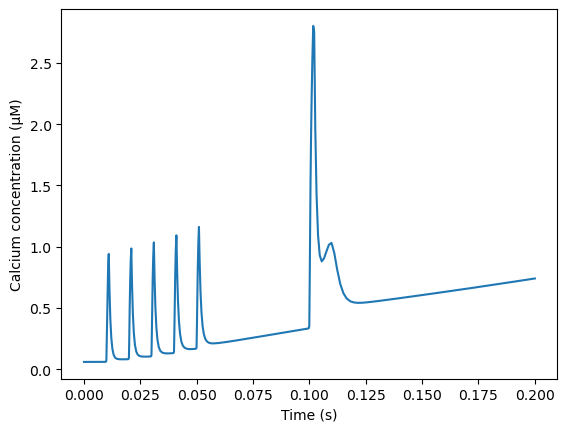

In [7]:
%matplotlib inline
plt.plot(modelCur.tvec, cytoCaVec)
plt.xlabel('Time (s)')
plt.ylabel('Calcium concentration (μM)')